In [1]:
import MulensModel as mm
import matplotlib.pyplot as plt
import numpy as np
from param_utils import Param, Params

In [2]:
def get_curve(args):
    my_1S2L_model = mm.Model({'t_0': 0, 'u_0': args[0],
                              't_E': args[1], 'rho': args[2], 'q': args[3], 's': args[4],
                              'alpha': args[5]})
    times = my_1S2L_model.set_times()
    times -= min(times)
    lc = my_1S2L_model.get_lc(source_flux=1)
    return times, lc

In [3]:
u_0 = Param("u_0", 0, np.sqrt(1), 0.5)
print(u_0)
print(u_0.get_sample_n(0, 1, 1))

(array([0.76060062]), array(['u_0: 0.76'], dtype='<U9'))


/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/model.py:267: UserWarning: No blend_flux not specified. Assuming blend_flux = zero.
  warnings.warn(
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)


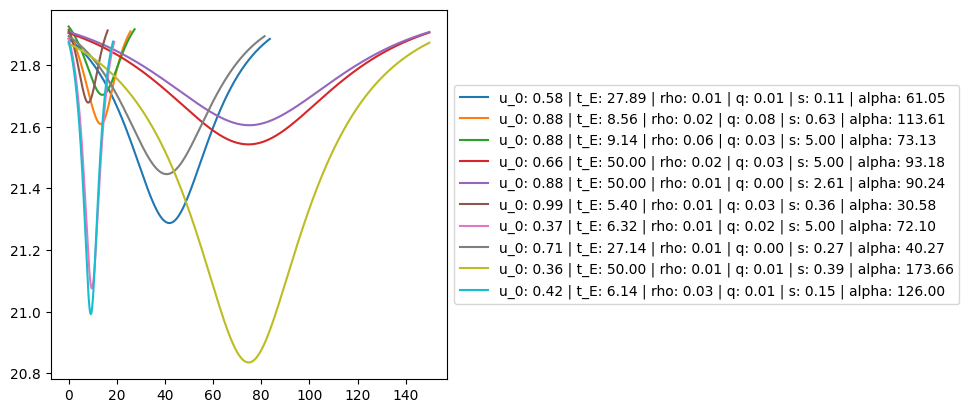

In [4]:
fig = plt.figure()
ax = plt.subplot(111)
for i in range(10):
    params = Params()
    args, labels = params.get_val()
    x, y = get_curve(args)
    ax.plot(x, y, label=' | '.join(labels))
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/tmp/ipykernel_9574/2124316833.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 640x480 with 0 Axes>

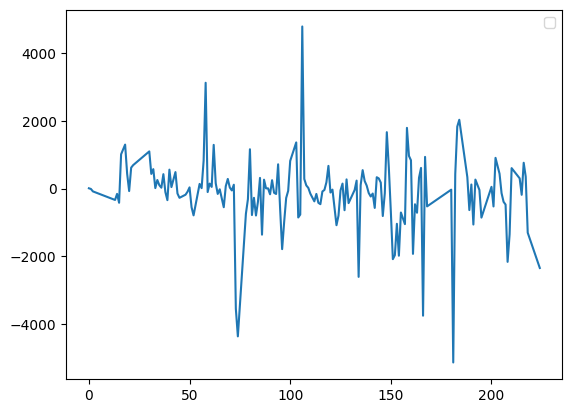

In [21]:
# add random light curve section to star as noise
from tqdm import tqdm
from astropy.io import ascii
import os

fig = plt.figure()
def choose_random_noise_curve(chunk_size=225, outlier_cutoff=3):
    fdir = "data/lightcurves/"
    directory = os.fsencode(fdir)
    files = os.listdir(directory)

    def grab_curve():
        # choose a random light curve
        selection_index = np.random.choice(len(files), replace=False) 
        curve = ascii.read(fdir + os.fsdecode(files[selection_index]), format='ipac')
        
        # grab all real values
        unmasked_inds = curve['cor_flux'].data.nonzero()

        # check there are real values
        if len(unmasked_inds[0]) == 0:
            return grab_curve()
    
        # first real index
        start = unmasked_inds[0][0]
        
        # fill x range to interpolate over
        x_filled = np.arange(curve['HJD'][start], curve['HJD'][start] + chunk_size)

        # grab real data + interpolate + return
        unmasked = curve['cor_flux'].data[unmasked_inds]
        unmasked_time = curve['HJD'][unmasked_inds]
        sample_interpolated = np.interp(x_filled, unmasked_time, unmasked)

        x_filled = x_filled - curve['HJD'][start]
        return x_filled, sample_interpolated

    x_i, y_i = grab_curve()

    # we check for variance with a moving average (faster than FFT methods)
    def moving_average(a, n=20):
        # n = 10 to capture large events (microlensing events) without filtering out noise
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    moving_avg = moving_average(y_i)
    curve_variance = max(moving_avg)
    max_variance = outlier_cutoff * np.std(y_i)
    
    if curve_variance > max_variance:
        #print("outliers in our noise curve, grabbing new data")
        x_i, y_i = grab_curve()

    return x_i, y_i

x, curve = choose_random_noise_curve()

fig = plt.figure()
plt.plot(x, curve)
plt.legend()
plt.show()

/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/model.py:267: UserWarning: No blend_flux not specified. Assuming blend_flux = zero.
  warnings.warn(
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)


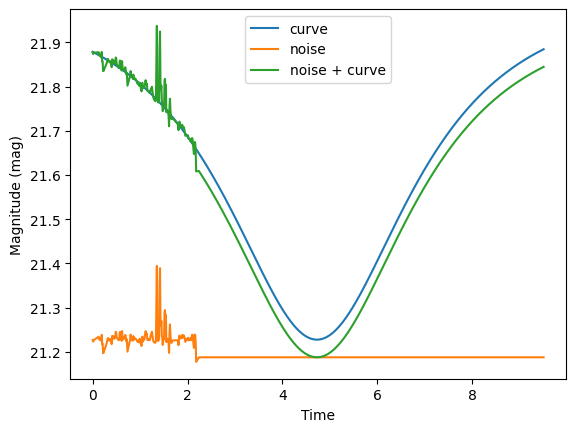

In [ ]:
params = Params()
args, labels = params.get_val()
x, y = get_curve(args)
noise_x, noise_y = choose_random_noise_curve()

fig = plt.figure()
plt.plot(x, y, label="curve")
noise_interp = np.interp(x, noise_x, noise_y)
noise_small = noise_interp * np.std(y) / (max(noise_interp) - min(noise_interp))
plt.plot(x, noise_small + min(y), label="noise")
plt.plot(x, y + noise_small, label="noise + curve")
plt.xlabel("Time")
plt.ylabel("Magnitude (mag)")
plt.legend()
plt.show()

In [43]:
def noisy_curve(args):
    x, y = get_curve(args)
    plt.plot(x, y)
    noise_x, noise_y = choose_random_noise_curve()
    domain_shift = (max(x) - min(x)) / (max(noise_x) - min(noise_x))
    noise_interp = np.interp(x, noise_x * domain_shift, noise_y)
    noise_small = noise_interp * 3 * np.std(y) / (max(noise_interp) - min(noise_interp))
    curve = y + noise_small
    return x, curve


In [44]:
params = Params()
args, labels = params.get_vals(10)
for arg in args:
    print(arg)
print("args:",','.join(['%.5f' % num for arg in args for num in arg]))

[0.44502969 0.81385507 0.45138057 0.87159118 0.90057588 0.48270408]
[ 0.64639973  0.96359605  0.5414196   0.57795515 20.61491458  6.3437528 ]
[42.64894955 50.         21.73334766  4.08626287  6.13887397 18.19289863]
[4.89394387 7.45671786 0.009      0.009      0.009      0.01125761]
[0.05630568 0.009      0.01217152 0.009      0.009      0.02543402]
[0.00529347 0.02405192 0.00589019 0.00793931 0.07647291 0.01588992]
[0.00723341 0.01391176 0.01627016 0.04313495 1.40957988 1.73521064]
[1.11604088 0.25117823 0.11923539 1.6000083  5.         5.        ]
[  2.41780824   0.47567306 103.81768866 146.30882637  27.45604669
 152.82874958]
[ 12.77797262  94.08060085 155.60666188  24.59413705  65.95463236
 111.93153075]
args: 0.44503,0.81386,0.45138,0.87159,0.90058,0.48270,0.64640,0.96360,0.54142,0.57796,20.61491,6.34375,42.64895,50.00000,21.73335,4.08626,6.13887,18.19290,4.89394,7.45672,0.00900,0.00900,0.00900,0.01126,0.05631,0.00900,0.01217,0.00900,0.00900,0.02543,0.00529,0.02405,0.00589,0.00794

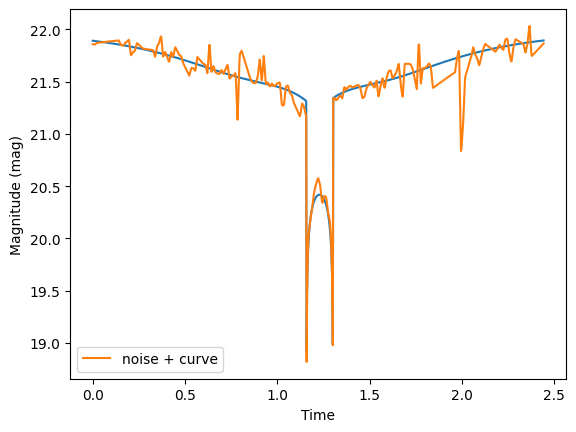

In [45]:
x_curve, y_curve = noisy_curve(args[0])
plt.plot(x_curve, y_curve, label="noise + curve")
plt.xlabel("Time")
plt.ylabel("Magnitude (mag)")
plt.legend()
plt.show()

[0.86650121 0.86495107 0.33828195 0.46474151 0.84929609 0.80471736]


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/model.py:267: UserWarning: No blend_flux not specified. Assuming blend_flux = zero.
  warnings.warn(
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)
100%|██████████| 1000/1000 [04:32<00:00,  3.67it/s]


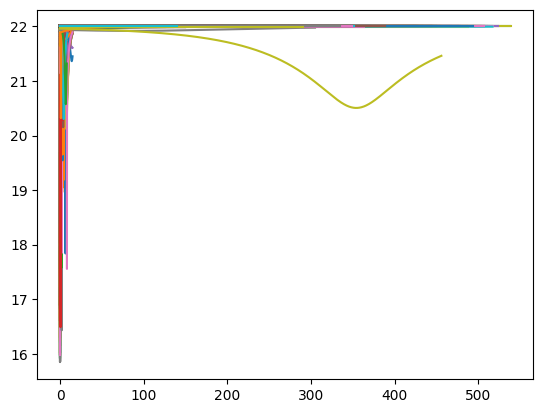

In [ ]:
arg_file = 'data/generated_lightcurves/params.csv'

#with open(arg_file, 'w') as f:
#    f.write('u_0, t_E, rho, q, s, alpha\n') # optional, just to clear the file, prolly should be replaced with ""

args, labels = params.get_vals(1000)
print(args[0])
init = 2000
for index in tqdm(range(init, init + 1000)):
    x_curve, y_curve = noisy_curve(args[index - init])
    seq = np.stack([x_curve, y_curve], axis=-1)      # shape [N, 2]

    with open(f'data/generated_lightcurves/xy/xy_{index}.npy', 'wb') as f:
        np.save(f, seq)

    with open(arg_file, 'a') as f:
        f.write(','.join(['%.5f' % num for num in args[index - init]]) + '\n')
    

100%|██████████| 2000/2000 [00:01<00:00, 1015.08it/s]


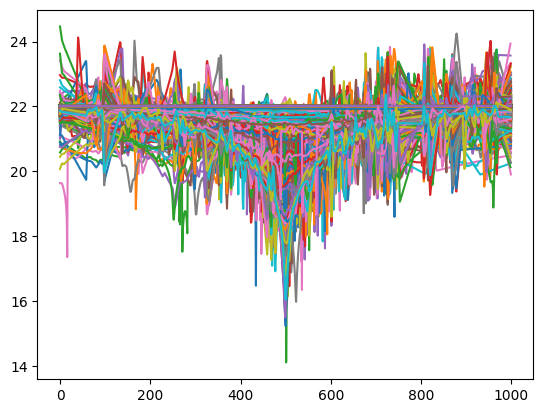

In [61]:
fdir = "data/generated_lightcurves/xy/"
directory = os.fsencode(fdir)

curves = []

i = 0
for file in tqdm(os.listdir(directory)):
    filename = os.fsdecode(file)
    xy = np.load(os.path.join(fdir, filename))  # shape (N, 2)

    x = xy[:,0]
    y = xy[:,1]
    plt.plot(np.arange(len(y)), y)
    i+=1